# GRAPE calculation of control fields for single-qubit rotation

Robert Johansson (robert@riken.jp)

In [4]:
!which python


/home/bond007/Desktop/thesis/qutip-notebooks/examples/.venv/bin/python


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

In [2]:
from qutip import *
from qutip.control import *

ImportError: Importing 'qutip.control' requires the 'qutip_qtrl' package. Install it with `pip install qutip-qtrl` (for more details, go to https://qutip-qtrl.readthedocs.io/).

In [3]:
T = 1
times = np.linspace(0, T, 100)

In [4]:
theta, phi = np.random.rand(2)

In [5]:
# target unitary transformation (random single qubit rotation)
U = rz(phi) * rx(theta); U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.98599999-0.0541191j  -0.00864377-0.15748152j]
 [ 0.00864377-0.15748152j  0.98599999+0.0541191j ]]

In [6]:
R = 150
H_ops = [sigmax(), sigmay(), sigmaz()]

H_labels = [r'$u_{x}$',
            r'$u_{y}$',
            r'$u_{z}$',
        ]

In [7]:
H0 = 0 * pi * sigmaz()

# GRAPE

In [8]:
from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

In [9]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [10]:
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [11]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   7.45s. Est. time left: 00:00:01:07
20.0%. Run time:  14.05s. Est. time left: 00:00:00:56
30.0%. Run time:  21.91s. Est. time left: 00:00:00:51
40.0%. Run time:  27.99s. Est. time left: 00:00:00:41
50.0%. Run time:  34.34s. Est. time left: 00:00:00:34
60.0%. Run time:  40.20s. Est. time left: 00:00:00:26
70.0%. Run time:  46.05s. Est. time left: 00:00:00:19
80.0%. Run time:  52.30s. Est. time left: 00:00:00:13
90.0%. Run time:  58.29s. Est. time left: 00:00:00:06
Total run time:  63.70s


## Plot control fields for iSWAP gate in the presense of single-qubit tunnelling

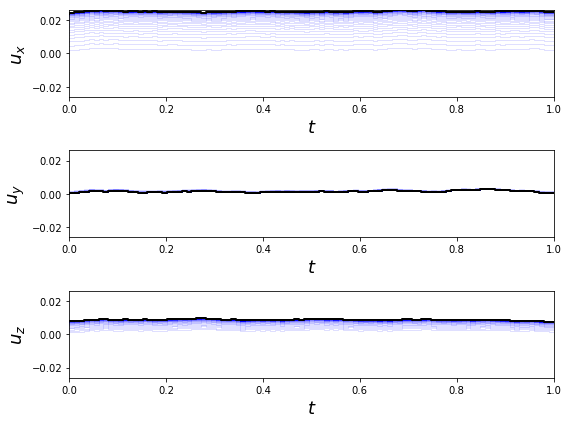

In [12]:
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [13]:
# target unitary
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.98599999-0.0541191j  -0.00864377-0.15748152j]
 [ 0.00864377-0.15748152j  0.98599999+0.0541191j ]]

In [14]:
# unitary from grape pulse
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.98599999-0.0541191j  -0.00864377-0.15748152j]
 [ 0.00864377-0.15748152j  0.98599999+0.0541191j ]]

In [15]:
# target / result overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(0.9999999999999987, 0.9999999999999973)

### Verify correctness of the Hamiltonian pulses by integration

In [16]:
c_ops = []

In [17]:
U_f_numerical = propagator(result.H_t, times[-1], c_ops, args={})

In [18]:
U_f_numerical

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[  9.87331556e-01-0.04867515j  -3.39865702e-04-0.15101991j]
 [  3.39865702e-04-0.15101991j   9.87331556e-01+0.04867515j]]

In [19]:
_overlap(U, U_f_numerical)

(0.9999289415682254+0j)

# Bloch sphere dynamics

In [20]:
psi0 = basis(2, 0)
e_ops = [sigmax(), sigmay(), sigmaz()]

In [21]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

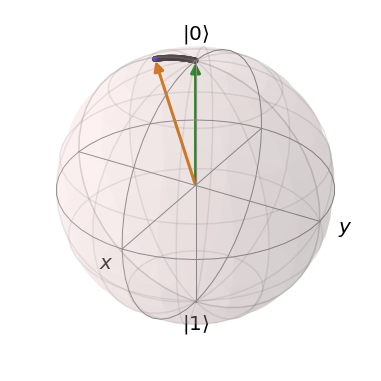

In [22]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()

# Process tomography

## Ideal gate

In [23]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
op_label = [["i", "x", "y", "z"]]

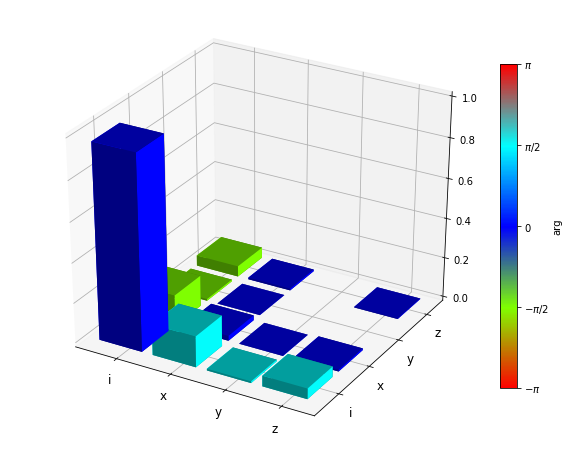

In [24]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Gate calculated using GRAPE

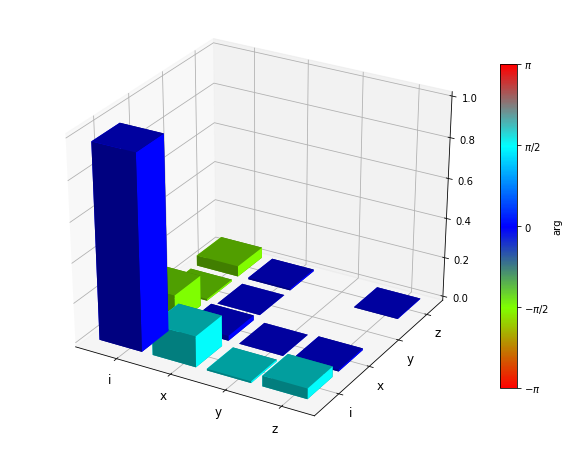

In [25]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(result.U_f) * spost(result.U_f.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [26]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
